In [ ]:
!unzip Archive.zip
!unzip Archive\ 2.zip

Archive:  Archive.zip
  inflating: MFO.gpkl                
  inflating: __MACOSX/._MFO.gpkl     
  inflating: prot_genes.pkl          
  inflating: __MACOSX/._prot_genes.pkl  
  inflating: prot_ordering.pkl       
  inflating: __MACOSX/._prot_ordering.pkl  
Archive:  Archive 2.zip
  inflating: gene_ordering_500.pkl   
  inflating: __MACOSX/._gene_ordering_500.pkl  
  inflating: MFO_500.pkl             
  inflating: __MACOSX/._MFO_500.pkl  
  inflating: prot_func_500.pkl       
  inflating: __MACOSX/._prot_func_500.pkl  


In [ ]:
!pip install bio

     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 2.3MB 18.1MB/s 


In [ ]:
!curl https://www.biofunctionprediction.org/cafa-targets/CAFA3_training_data.tgz --output cafa.tgz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 21.6M  100 21.6M    0     0  18.4M      0  0:00:01  0:00:01 --:--:-- 18.4M


In [ ]:
!tar -xvzf cafa.tgz

CAFA3_training_data/
CAFA3_training_data/00README.txt
CAFA3_training_data/uniprot_sprot_exp.txt
CAFA3_training_data/uniprot_sprot_exp.fasta


In [ ]:
from collections import Counter
from itertools import chain

from pickle import load, dump
from tqdm import tqdm

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from Bio import SeqIO


def gene2func(g, o, G):
  vec = np.zeros(len(o))
  vec[[o[n] for n in nx.dfs_preorder_nodes(G, g)]] = 1
  return vec


def prot2func(p, prot_genes, ord, G):
  vec = np.zeros(len(ord))
  for g in prot_genes[p]:
    vec += gene2func(g, ord, G)
  vec[0 < vec] = 1
  return vec

In [ ]:
ordering = load(open('/content/prot_ordering.pkl', 'rb'))
prot_genes = load(open('/content/prot_genes.pkl', 'rb'))
MFO = nx.read_gpickle('/content/MFO.gpkl')

In [ ]:
only_root = 0
filtered_prots = []
prot_annotations = []

for prot in tqdm(prot_genes.keys()):
  func = prot2func(prot, prot_genes, ordering, MFO)
  if 1 < func.sum():
    prot_annotations.append(func)
    filtered_prots.append(prot)
  else:
    only_root += 1

print(f'\nremoved {only_root} proteins with only root node function annotation')

100%|██████████| 35086/35086 [00:04<00:00, 7482.42it/s]


removed 194 proteins with only root node function annotation


found 1731 genes occuring more than N_FILTER times in the dataset


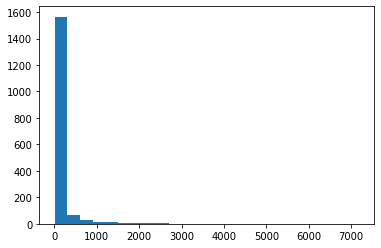

In [ ]:
N_FILTER = 10
func_cnt = np.vstack(prot_annotations).sum(axis=0)
plt.hist(func_cnt[(N_FILTER <= func_cnt) & (func_cnt <= 10000)], bins='rice')

print(f'found {len(func_cnt[func_cnt >= N_FILTER])} genes occuring more than N_FILTER times in the dataset')

In [ ]:
filtered_nodes = []
rev_ordering = {i:g for g, i in ordering.items()}
filtered_genes = [rev_ordering[i] for i, cnt in enumerate(func_cnt) if N_FILTER <= cnt]

for gene in filtered_genes:
  filtered_nodes.extend([n for n in nx.dfs_preorder_nodes(MFO, gene)])

MFO_500 = MFO.subgraph(filtered_genes)
print(f'nodes: {MFO_500.number_of_nodes()} - edges: {MFO_500.number_of_edges()}')

nodes: 1731 - edges: 2287


In [ ]:
filtered_indexes = {g:i for g, i in ordering.items() if g in MFO_500}
prot_func_500 = {p:prot2func(p, prot_genes, ordering, MFO)[list(filtered_indexes.values())] for p in filtered_prots}
ordering_500 = {g:new_idx for new_idx, (g, old_idx) in enumerate(sorted(filtered_indexes.items(), key=lambda i: i[1]))}

In [ ]:
degrees_map = [(ordering_500[f],d) for f, d in MFO_500.in_degree(MFO_500.nodes())]
degrees = np.zeros(len(ordering_500))
for idx, d in degrees_map:
  degrees[idx] = d

irreducibles = np.array([1 if d < 2 else 0 for d in degrees])
len(degrees)

1731

In [ ]:
dump(ordering_500, open('/content/gene_ordering_10.pkl', 'wb'))
dump(prot_func_500, open('/content/prot_func_10.pkl', 'wb'))
nx.write_gpickle(MFO_500.copy(), '/content/MFO_10.pkl')

In [ ]:
len_sum, prot_seq, acids = 0, {}, set()

for record in SeqIO.parse("/content/CAFA3_training_data/uniprot_sprot_exp.fasta", "fasta"):
    if record.id in prot_func_500 and len(record.seq) <= 1000:
      prot_seq[record.id] = record.seq
      len_sum += len(record.seq)
      for a in record.seq: acids.add(a)

print(len(prot_seq), len_sum/len(prot_seq), len(acids))
print(sum([f.sum() for _, f in prot_func_500.items()])/len(prot_func_500))

31289 430.87644220013425 25
9.76928808896022


In [ ]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils import data
import torch.nn.functional as F
from torch.autograd import Variable
from opt_einsum import contract_expression

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


NUM_AMINO = 25
NUM_NODES = 1731
NUM_FEATURES = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Labeller(nn.Module):
  def __init__(self, use_graph = False, use_spectral = False, k = 1, gcn_layers = 1, agg = 'mean'):
    super(Labeller, self).__init__()
    self.use_graph = use_graph
    self.use_spectral = use_spectral
    self.k = k 
    self.gcn_layers = gcn_layers 
    self.agg = agg
    self.embedding = nn.Embedding(NUM_AMINO, NUM_FEATURES)
    self.conv1 = nn.Conv1d(NUM_FEATURES, 32, 3, padding=1)
    self.conv2 = nn.Conv1d(32, 64, 3, padding=2, dilation=2)
    self.conv3 = nn.Conv1d(64, 128, 3, padding=4, dilation=4)
    self.conv4 = nn.Conv1d(128, 256, 3, padding=8, dilation=8)
    self.conv5 = nn.Conv1d(256, 512, 3, padding=16, dilation=16)
    self.conv6 = nn.Conv1d(512, 512, 3, padding=32, dilation=32)
    self.elu = nn.ELU()
    self.leaky = nn.LeakyReLU()
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim = 1)
    self.dropout = nn.Dropout(0.3)
    self.fc = nn.Linear(512, k * NUM_NODES)

  def weights_init(self, m):
    if isinstance(m, nn.Conv1d):
      torch.nn.init.xavier_uniform_(m.weight.data)
      m.bias.data.fill_(0.0)

  def forward(self, input, unpacked_masks, adj = None, spectral_features = None):
    x=input
    x = self.embedding(x)
    x = torch.transpose(x, 1, 2)

    unpacked_masks = torch.unsqueeze(unpacked_masks, 1)
   
    x = self.conv1(x)
    x = torch.mul(x, unpacked_masks)
    
    x = self.elu(x)
    x = self.conv2(x)

    x = torch.mul(x, unpacked_masks)
    x = self.elu(x)

    x = self.conv3(x)

    x = torch.mul(x, unpacked_masks)
    x = self.elu(x)

    x = self.conv4(x)

    x = torch.mul(x, unpacked_masks)
    x = self.elu(x)

    x = self.conv5(x)

    x = torch.mul(x, unpacked_masks)
    x = self.elu(x)

    x = self.conv6(x)
    x = torch.mul(x, unpacked_masks)
    x = self.elu(x)

    
    x = torch.transpose(x, 1, 2)
    x = self.dropout(x)
    
    x = self.fc(x)
    unpacked_masks = torch.transpose(unpacked_masks, 1, 2)

    x = torch.sum(x * unpacked_masks, dim = 1) / torch.sum(unpacked_masks, dim = 1) # first logits

    b_size = x.shape[0]

    logits = torch.reshape(x, (b_size, self.k, NUM_NODES))
    
    return logits #logits.squeeze(-1)


class MeetSemiLattice():
	def __init__(self, L, ordering):
		self.L = L
		self.ordering = ordering
		self.DLT, self.DLT_inv = self._compute_DLT()

	def _compute_DLT(self):
		F = np.zeros((self.L.number_of_nodes(), self.L.number_of_nodes()))
		lengths = dict(nx.all_pairs_shortest_path_length(self.L))

		for n1 in self.L.nodes():
			for n2 in self.L.nodes():
				if n2 in lengths[n1]:
					F[self.ordering[n1]][self.ordering[n2]] = 1

		return np.linalg.inv(F), F


class MeetConv(nn.Module):
  def __init__(self, L, in_channels=1, out_channels=1, bias=True, irreducibles=[], device=None):
    super().__init__()
    self.has_bias = bias
    self.expr_shape = None
    self.size = L.L.number_of_nodes()
    self.DLT = Variable(torch.Tensor(L.DLT))
    self.DLT_inv = Variable(torch.Tensor(L.DLT_inv))
    
    self.mask = Variable(torch.Tensor(irreducibles))
    #self.mask = torch.zeros(self.size)
    #self.mask[[0] + [ordering[e[0]] for e in MFO_500.in_edges('GO:0003674')]] = 1

    self.filter = nn.Parameter(torch.empty(in_channels, out_channels, self.size))
    nn.init.kaiming_normal_(self.filter, a=0.01)
    
    if self.has_bias:
      self.bias = nn.Parameter(torch.empty(out_channels, self.size))
      nn.init.kaiming_normal_(self.bias, a=0.01)

    if device is not None:
      self.DLT = self.DLT.to(device)
      self.mask = self.mask.to(device)
      self.DLT_inv = self.DLT_inv.to(device)

  def forward(self, x):
    if not self.expr_shape == x.shape:
      self.expr_shape = x.shape
      self.expr = contract_expression('nm,com,ml,bcl->bon', self.DLT_inv, self.filter.shape, self.DLT, x.shape, constants=[0, 2])

    #filt_fourier = (self.DLT_inv.T @ torch.reshape(self.filter * self.mask, (self.size, -1))).reshape(self.filter.shape)
    x = self.expr((self.DLT_inv.T @ torch.reshape(self.filter * self.mask, (self.size, -1))).reshape(self.filter.shape), x, backend='torch')
    #x = self.expr(self.filter, x, backend='torch')
    return x + (self.bias if self.has_bias else 0)


class JoinConv(nn.Module):
  def __init__(self, L, in_channels=1, out_channels=1, bias=True, device=None):
    super().__init__()
    self.has_bias = bias
    self.expr_shape = None
    self.size = L.L.number_of_nodes()
    self.DLT = Variable(torch.Tensor(L.DLT.T))
    self.DLT_inv = Variable(torch.inverse(self.DLT))

    self.mask = torch.zeros(self.size)
    self.mask[[0] + [ordering[e[0]] for e in MFO_500.in_edges('GO:0003674')]] = 1

    self.filter = nn.Parameter(torch.empty(in_channels, out_channels, self.size))
    nn.init.kaiming_normal_(self.filter, a=0.01)
    
    if self.has_bias:
      self.bias = nn.Parameter(torch.empty(out_channels, self.size))
      nn.init.kaiming_normal_(self.bias, a=0.01)

    if device is not None:
      self.DLT = self.DLT.to(device)
      self.mask = self.mask.to(device)
      self.DLT_inv = self.DLT_inv.to(device)

  def forward(self, x):
    if not self.expr_shape == x.shape:
      self.expr_shape = x.shape
      self.expr = contract_expression('nm,com,ml,bcl->bon', self.DLT_inv, self.filter.shape, self.DLT, x.shape, constants=[0, 2])

    #filt_fourier = torch.einsum('nm,m,com->con', self.DLT_inv.T, self.mask, self.filter)
    #x = self.expr(filt_fourier, x, backend='torch')
    x = self.expr(self.filter, x, backend='torch')
    return x + (self.bias if self.has_bias else 0)


class ProtNet(nn.Module):
  def __init__(self, L, in_channels=1, out_channels=1, irr=[], device=None):
    super().__init__()
    latent_dim = 16
    self.Mconv1 = MeetConv(L, in_channels=in_channels, out_channels=latent_dim, irreducibles=irr, device=device)
    self.Jconv1 = MeetConv(L, in_channels=in_channels, out_channels=latent_dim, irreducibles=irr, bias=False, device=device)
    self.Mconv2 = MeetConv(L, in_channels=latent_dim, out_channels=latent_dim, irreducibles=irr, device=device)
    self.Jconv2 = MeetConv(L, in_channels=latent_dim, out_channels=latent_dim, irreducibles=irr, bias=False, device=device)
    self.Mconv3 = MeetConv(L, in_channels=latent_dim, out_channels=out_channels, irreducibles=irr, device=device)
    self.Jconv3 = MeetConv(L, in_channels=latent_dim, out_channels=out_channels, irreducibles=irr, bias=False, device=device)
  
  def forward(self, x):
    x = nn.LeakyReLU()(self.Mconv1(x) + self.Jconv1(x))
    #x = nn.LeakyReLU()(self.Mconv2(x) + self.Jconv2(x))
    x = self.Mconv3(x) + self.Jconv3(x)
    return x #self.conv2(nn.ReLU()(self.conv1(x))) #torch.squeeze(self.conv(x), dim=1)#torch.sum(self.conv(x), dim=2)


class CAFADataset(data.Dataset):

  def __init__(self, prot_sequences, amino_acids, functional_annotations):
    self.AAMap = {A:idx for idx, A in enumerate(amino_acids)}
    self.max_len = max([len(s) for _, s in prot_sequences])
    self.FA = functional_annotations
    self.prot_seq = prot_sequences
  
  def __len__(self):
    return len(prot_seq)
  
  def __getitem__(self, idx):
    prot_id, seq = self.prot_seq[idx]
    pad = [self.AAMap['X'] for _ in range(self.max_len - len(seq))]
    mask = np.array(1. * (np.arange(self.max_len) < len(seq)), dtype=np.float32)
    return np.array([self.AAMap[a] for a in seq] + pad), mask, np.array(self.FA[prot_id], dtype=np.float32)


In [ ]:
np.ones(MFO_500.number_of_nodes()).shape

(1731,)

In [ ]:
(prot_net.Mconv1.DLT_inv.T @ torch.reshape(prot_net.Mconv1.filter * prot_net.Mconv1.mask, (prot_net.Mconv1.size, -1))).reshape(prot_net.Mconv1.filter.shape).shape
#torch.einsum('nm,m,com->con', prot_net.Mconv1.DLT_inv.T, prot_net.Mconv1.mask, prot_net.Mconv1.filter)

torch.Size([4, 16, 1731])

In [ ]:
 ((prot_net.Mconv3.DLT_inv.T) @ ((prot_net.Mconv3.mask * prot_net.Mconv3.filter).reshape(1731, -1))).reshape(prot_net.Mconv3.filter.shape)

tensor([[[-6.0377,  2.2402,  1.7527,  ...,  0.1027, -0.1540,  0.2264]],

        [[ 0.1447,  0.1106, -0.0929,  ...,  0.0103,  0.0404, -0.0065]],

        [[ 0.0000, -0.0205,  0.0000,  ...,  0.0075,  0.0272, -0.0576]],

        ...,

        [[ 0.0000,  0.0126,  0.0000,  ...,  0.0667, -0.2828,  0.0320]],

        [[-0.0316,  0.1823,  0.1095,  ..., -0.0149, -0.0502,  0.0442]],

        [[ 0.0000, -0.0224,  0.0000,  ...,  0.0131, -0.0282,  0.0311]]],
       device='cuda:0', grad_fn=<ViewBackward>)

In [ ]:
#filt_shape = prot_net.Mconv3.filter.shape
#(torch.cat((filt_shape[0] * filt_shape[1]) * [prot_net.Mconv3.mask]).reshape(filt_shape) * prot_net.Mconv3.filter) @ prot_net.Mconv3.DLT_inv
(prot_net.Mconv3.DLT_inv.T @ (prot_net.Mconv3.filter * prot_net.Mconv3.mask).reshape(prot_net.Mconv3.filter.shape[2], -1)).reshape(prot_net.Mconv3.filter.shape).shape

torch.Size([16, 1, 1731])

In [ ]:
train, eval = train_test_split(np.arange(len(prot_seq)), train_size=0.68, random_state=42)
val, test = train_test_split(eval, train_size=0.55, random_state=42)
CAFA = CAFADataset(list(prot_seq.items()), acids, prot_func_500)

train_loader = data.DataLoader([CAFA[i] for i in train], batch_size=32, shuffle=True, drop_last=True)
test_loader = data.DataLoader([CAFA[i] for i in test], batch_size=128, shuffle=True)
val_loader = data.DataLoader([CAFA[i] for i in val], batch_size=128, shuffle=True)
# all_ = np.stack([CAFA[i][2] for i in train]).sum(axis=0)
# weights = 2 * np.stack([len(train) - all_, all_])
# weights = len(train) / weights
# weights[np.isinf(weights)] = 1.
# weights = torch.Tensor(weights).to(device)

best_e, best_val = 0, 0
loss_hist, val_hist = [], []
k, epochs, patience = 4, 100, 10

net = Labeller(k=k).to(device)
criterion = nn.BCELoss(reduction='none').to(device)
Protein_Ontology = MeetSemiLattice(MFO_500, ordering_500)
prot_net = ProtNet(Protein_Ontology, in_channels=k, irr=irreducibles, device=device).to(device)

optimizer = optim.Adam(chain(net.parameters(), prot_net.parameters()))
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

for e in range(epochs):

  for i, (x, mask, y) in enumerate(tqdm(train_loader)):
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    optimizer.zero_grad()
    y_pred = torch.squeeze(prot_net(net(x, mask)))
    #y_pred = torch.sum(net(x, mask), dim=1)
    loss = criterion(torch.sigmoid(y_pred), y).mean()
    #loss = (criterion(torch.sigmoid(y_pred), y) * (weights[1, :None]*y + weights[0, :None]*(1 - y))).sum()
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())
    
  with torch.no_grad():
    
    preds, target = [], []
    for x, mask, y in val_loader:
      target.append(y)
      x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
      y_pred = torch.squeeze(prot_net(net(x, mask)))
      #y_pred = torch.sum(net(x, mask), dim=1)
      preds.append((1 * (y_pred > 0)).detach().cpu().numpy())
    
    val_hist.append(f1_score(np.vstack(preds), np.vstack(target), average='samples'))
    print(f'epoch {e} - val f1: {val_hist[-1]}')
    lr_scheduler.step(val_hist[-1])
    if best_val < val_hist[-1]:
      best_val = val_hist[-1]
      best_e = e

    if val_hist[-1] < best_val and patience + best_e < e:
      print(f'validation f1 did not improve for {patience} epochs - stopping training - best epoch: {best_e}')
      break

plt.plot(loss_hist)
plt.show()
plt.plot(val_hist)
plt.show()


  5%|▌         | 36/664 [00:09<02:45,  3.79it/s]


KeyboardInterrupt: ignored

In [ ]:
best_e, epochs, patience = 0, 200, 20

for e in range(epochs):

  for i, (x, mask, y) in enumerate(tqdm(train_loader)):
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    optimizer.zero_grad()
    y_pred = torch.squeeze(prot_net(net(x, mask)))
    loss = criterion(torch.sigmoid(y_pred), y).mean()
    #loss = (criterion(torch.sigmoid(y_pred), y) * (weights[1, :None]*y + weights[0, :None]*(1 - y))).mean()
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())
    
  with torch.no_grad():
    
    preds, target = [], []
    for x, mask, y in tqdm(val_loader):
      target.append(y)
      x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
      y_pred = torch.squeeze(prot_net(net(x, mask)))
      preds.append((1 * (y_pred > 0)).detach().cpu().numpy())
    
    val_hist.append(f1_score(np.vstack(preds), np.vstack(target), average='samples'))
    print(f'epoch {e} - val f1: {val_hist[-1]}')

    if patience <= len(val_hist) and val_hist[-1] < val_hist[-patience:-1]):
      print(f'validation f1 did not improve for {patience} epochs - stopping training.')
      break

plt.plot(loss_hist)
plt.show()
plt.plot(val_hist)
plt.show()

In [ ]:
with torch.no_grad():
    
  preds, target = [], []
  for x, mask, y in tqdm(test_loader):
    target.append(y)
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    y_pred = net(x, mask)
    preds.append((1 * (y_pred > 0)).detach().cpu().numpy())

T, P = np.vstack(target), np.vstack(preds)
test_f1 = f1_score(P, T, average="samples")
test_f1_500 = f1_score(P[:, :116], T[:, :116], average="samples")

print(confusion_matrix(T.flatten(), P.flatten()))
print(confusion_matrix(T[:, :116].flatten(), P[:, :116].flatten()))
print(f'test full f1 score: {test_f1} - test 500<n_func f1 score: {test_f1_500}')


100%|██████████| 36/36 [00:04<00:00,  7.82it/s]


[[1691584    9800]
 [  21071   17449]]
test full f1 score: 0.520423332205513 - test 500<n_func f1 score: 0.6222610426874416


In [ ]:
with torch.no_grad():
    
  preds, target = [], []
  for x, mask, y in tqdm(test_loader):
    target.append(y)
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    y_pred = net(x, mask)
    preds.append((1 * (y_pred > 0)).detach().cpu().numpy())

T, P = np.vstack(target), np.vstack(preds)
test_f1 = f1_score(P, T, average="samples")
test_f1_500 = f1_score(P[:, :116], T[:, :116], average="samples")

print(confusion_matrix(T.flatten(), P.flatten()))
print(confusion_matrix(T[:, :116].flatten(), P[:, :116].flatten()))
print(f'test full f1 score: {test_f1} - test 500<n_func f1 score: {test_f1_500}')


100%|██████████| 36/36 [00:04<00:00,  7.86it/s]


[[1645693   46096]
 [  15083   23432]]
[[479388  19900]
 [  7272  16136]]
test full f1 score: 0.4239344878961733 - test 500<n_func f1 score: 0.5423398217224255


In [ ]:
with torch.no_grad():
    
  preds, target = [], []
  for x, mask, y in tqdm(test_loader):
    target.append(y)
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    y_pred = torch.squeeze(prot_net(net(x, mask)))
    preds.append((1 * (y_pred > 0)).detach().cpu().numpy())

T, P = np.vstack(target), np.vstack(preds)
test_f1 = f1_score(P, T, average="samples")
test_f1_500 = f1_score(P[:, :116], T[:, :116], average="samples")

print(confusion_matrix(T.flatten(), P.flatten()))
print(confusion_matrix(T[:, :116].flatten(), P[:, :116].flatten()))
print(f'test full f1 score: {test_f1} - test 500<n_func f1 score: {test_f1_500}')


100%|██████████| 36/36 [00:06<00:00,  5.69it/s]


[[1683255    8534]
 [  21304   17211]]
[[494596   4692]
 [ 10120  13288]]
test full f1 score: 0.5304986435873551 - test 500<n_func f1 score: 0.6355109023590165


In [ ]:
with torch.no_grad():
    
  preds, target = [], []
  for x, mask, y in test_loader:
    target.append(y)
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    y_pred = torch.squeeze(prot_net(net(x, mask)))
    preds.append((1 * (y_pred > 0)).detach().cpu().numpy())

T, P = np.vstack(target), np.vstack(preds)
test_f1 = f1_score(P, T, average="samples")
test_f1_500 = f1_score(P[:, :116], T[:, :116], average="samples")

print(confusion_matrix(T.flatten(), P.flatten()))
print(confusion_matrix(T[:, :116].flatten(), P[:, :116].flatten()))
print(f'test full f1 score: {test_f1} - test 500<n_func f1 score: {test_f1_500}')


[[1681505   10284]
 [  20426   18089]]
[[493449   5839]
 [  9487  13921]]
test full f1 score: 0.5333986542059482 - test 500<n_func f1 score: 0.6380136610599714


In [ ]:
with torch.no_grad():
    
  preds, target = [], []
  for x, mask, y in test_loader:
    target.append(y)
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    y_pred = torch.squeeze(prot_net(net(x, mask)))
    preds.append((1 * (y_pred > 0)).detach().cpu().numpy())

T, P = np.vstack(target), np.vstack(preds)
test_f1 = f1_score(P, T, average="samples")
test_f1_500 = f1_score(P[:, :116], T[:, :116], average="samples")

print(confusion_matrix(T.flatten(), P.flatten()))
print(confusion_matrix(T[:, :116].flatten(), P[:, :116].flatten()))
print(f'test full f1 score: {test_f1} - test 500<n_func f1 score: {test_f1_500}')


[[7744411   11936]
 [  26111   17428]]
[[497637   5206]
 [  8403  11450]]
test full f1 score: 0.4680573679768234 - test 500<n_func f1 score: 0.6350108079314918


In [ ]:
with torch.no_grad():
    
  preds, target = [], []
  for x, mask, y in test_loader:
    target.append(y)
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    #y_pred = torch.squeeze(prot_net(net(x, mask)))
    y_pred = torch.sum(net(x, mask), dim=1)
    preds.append((1 * (y_pred > 0)).detach().cpu().numpy())

T, P = np.vstack(target), np.vstack(preds)
test_f1 = f1_score(P, T, average="samples")
test_f1_500 = f1_score(P[:, :116], T[:, :116], average="samples")

print(confusion_matrix(T.flatten(), P.flatten()))
print(confusion_matrix(T[:, :116].flatten(), P[:, :116].flatten()))
print(f'test full f1 score: {test_f1} - test 500<n_func f1 score: {test_f1_500}')


[[7750695    5652]
 [  29681   13858]]
[[500570   2273]
 [ 10372   9481]]
test full f1 score: 0.4395155768293883 - test 500<n_func f1 score: 0.6149030153230435


In [ ]:
torch.save({
    'test_f1_100': test_f1,
    'test_f1_500': test_f1_500,
    'labeller_state_dict': net.state_dict(),
    'lattice_state_dict': prot_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/content/labeller-100p-20e-32b.pth')

In [ ]:
torch.save({
    'test_f1_100': test_f1,
    'test_f1_500': test_f1_500,
    'labeller_state_dict': net.state_dict(),
    'lattice_state_dict': prot_net.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, '/content/real_opti.pth')


0it [00:00, ?it/s]
1it [00:00,  1.16it/s]
2it [00:01,  1.16it/s]
3it [00:02,  1.16it/s]
4it [00:03,  1.16it/s]
5it [00:04,  1.16it/s]
6it [00:05,  1.16it/s]
7it [00:06,  1.16it/s]
8it [00:06,  1.16it/s]
9it [00:07,  1.16it/s]
10it [00:08,  1.16it/s]
11it [00:09,  1.16it/s]
12it [00:10,  1.17it/s]
13it [00:11,  1.17it/s]
14it [00:12,  1.17it/s]
15it [00:12,  1.16it/s]
16it [00:13,  1.16it/s]
17it [00:14,  1.17it/s]
18it [00:15,  1.17it/s]
19it [00:16,  1.16it/s]
20it [00:17,  1.16it/s]
21it [00:18,  1.17it/s]
22it [00:18,  1.17it/s]
23it [00:19,  1.17it/s]
24it [00:20,  1.17it/s]
25it [00:21,  1.17it/s]
26it [00:22,  1.17it/s]
27it [00:23,  1.17it/s]
28it [00:24,  1.18it/s]
29it [00:24,  1.18it/s]
30it [00:25,  1.19it/s]
31it [00:26,  1.19it/s]
32it [00:27,  1.19it/s]
33it [00:28,  1.19it/s]
34it [00:29,  1.19it/s]
35it [00:29,  1.19it/s]
36it [00:30,  1.19it/s]
37it [00:31,  1.20it/s]
38it [00:32,  1.20it/s]
39it [00:33,  1.20it/s]
40it [00:34,  1.20it/s]
41it [00:34,  1.20it/s]
42it 

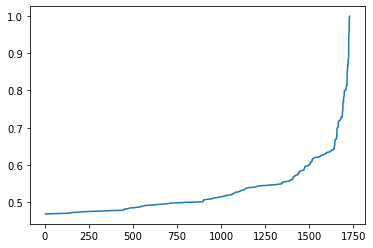

In [ ]:
f1s = []
for i in tqdm(reversed(range(2,T.shape[1]))):
  f1s.append(f1_score(P[:, :i], T[:, :i], average='samples'))

plt.plot(list(range(2, T.shape[1])), f1s)

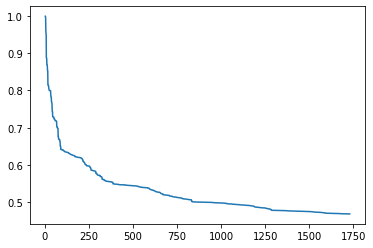

In [ ]:
plt.plot(list(range(2, T.shape[1])), np.flip(f1s))

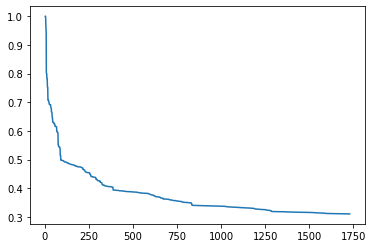

In [ ]:
plt.plot(list(range(2, T.shape[1])), f1s)

In [ ]:
embedding_loader = data.DataLoader([CAFA[i] for i in range(len(CAFA))], batch_size=128, shuffle=False)

with torch.no_grad():
    
  embeddings, target = [], []
  for x, mask, y in tqdm(embedding_loader):
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    embeddings.append(net(x, mask).detach().cpu().numpy())
    target.append(y)


class CAFAEmbeddedDataset(data.Dataset):

  def __init__(self, embeddings, target):
    self.embeddings = embeddings
    self.target = target
  
  def __len__(self):
    return self.embeddings.shape[0]
  
  def __getitem__(self, idx):
    return self.embeddings[idx], self.target[idx]


E_CAFA = CAFAEmbeddedDataset(np.vstack(embeddings), target)

E_train_loader = data.DataLoader([E_CAFA[i] for i in train], batch_size=32, shuffle=True, drop_last=True)
E_test_loader = data.DataLoader([E_CAFA[i] for i in test], batch_size=128, shuffle=True)
E_val_loader = data.DataLoader([E_CAFA[i] for i in val], batch_size=128, shuffle=True)


In [ ]:
dump(embeddings, open('/content/embeddings.pkl', 'wb'))
dump(targets, open('/content/targets.pkl', 'wb'))

In [ ]:
best_e, best_val = 0, 0
loss_hist, val_hist = [], []
k, epochs, patience = 4, 100, 10

#net = Labeller(k=k).to(device)
criterion = nn.BCELoss(reduction='none').to(device)
Protein_Ontology = MeetSemiLattice(MFO_500, ordering_500)
prot_net = ProtNet(Protein_Ontology, in_channels=k, device=device).to(device)

optimizer = optim.Adam(prot_net.parameters())
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5, verbose=True)

for e in range(epochs):

  for i, (x, mask, y) in enumerate(tqdm(E_train_loader)):
    x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
    optimizer.zero_grad()
    y_pred = torch.squeeze(prot_net(x, mask))
    #y_pred = torch.sum(net(x, mask), dim=1)
    loss = criterion(torch.sigmoid(y_pred), y).mean()
    #loss = (criterion(torch.sigmoid(y_pred), y) * (weights[1, :None]*y + weights[0, :None]*(1 - y))).sum()
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())
    
  with torch.no_grad():
    
    preds, target = [], []
    for x, mask, y in E_val_loader:
      target.append(y)
      x, mask, y = torch.LongTensor(x).to(device), torch.Tensor(mask).to(device), torch.Tensor(y).to(device)
      y_pred = torch.squeeze(prot_net(x, mask))
      #y_pred = torch.sum(net(x, mask), dim=1)
      preds.append((1 * (y_pred > 0)).detach().cpu().numpy())
    
    val_hist.append(f1_score(np.vstack(preds), np.vstack(target), average='samples'))
    print(f'epoch {e} - val f1: {val_hist[-1]}')
    lr_scheduler.step(val_hist[-1])
    if best_val < val_hist[-1]:
      best_val = val_hist[-1]
      best_e = e

    if val_hist[-1] < best_val and patience + best_e < e:
      print(f'validation f1 did not improve for {patience} epochs - stopping training - best epoch: {best_e}')
      break